In [35]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import SimpleITK as sitk
import torch
import json
import numpy as np
from copy import deepcopy
import pandas as pd
from matplotlib.patches import Patch
%matplotlib inline

## Generate index map

In [ ]:
# Get specified slice
index_map = pd.read_csv('abd_index_map.csv')
indices = [1861, 1832, 1898, 1897, 1919, 1944]
slices_to_viz = [(index_map.loc[i, 'slice'], index_map.loc[i,'case']) for i in indices]

In [ ]:
from config import LABEL_SUBSETS
label_subsets = LABEL_SUBSETS
from config import ROOT_PATH
data_src = Path(ROOT_PATH) 

train_dataset_names = [
            "Dataset004_LiTS",
            "Dataset005_BTCV",
            "Dataset008_abdomenct1k",
            "Dataset009_learn2reg",
            "Dataset003_TotalSegmentator",
        ]
test_dataset_names = deepcopy(train_dataset_names)
test_dataset_names.append("Dataset001_amos")

index_map = []

train_labels = [label_subsets[ds_name] for ds_name in train_dataset_names]
train_labels = np.unique([xx for x in train_labels for xx in x])
train_labels = {l: i + 1 for i, l in enumerate(train_labels)}
n_cls = len(train_labels) + 1
print(n_cls)
print(train_labels)
test_dataset_labels = {}

test_dataset_cases: dict[str, list] = {}

for ds_name in test_dataset_names:
    ds_dir = ds_name
    with open(
        data_src / "nnUNet_preprocessed" / ds_dir / "dataset.json", "r"
    ) as f:
        test_dataset_labels[ds_name] = json.load(f)["labels"]

    with open(
        data_src / "nnUNet_preprocessed" / ds_dir / "splits_final.json", "r"
    ) as f:
        fold_splits = json.load(f)
        test_dataset_cases[ds_name] = fold_splits[0]["val"]


test_ds_name = "Dataset001_amos"
imgs = []
segs = []
for slice, case in slices_to_viz:
# slice, case  = slices_to_viz[1]
    # print(slice, case)
    all_test_ds_labels = test_dataset_labels[test_ds_name]
    test_ds_labels = label_subsets[test_ds_name]
        # Mask the labels that are not present in the dataset
    label_mask = np.array(
            [True if l in test_ds_labels else False for l in train_labels]
        )
    intersection_labels = [t for t in train_labels if t in test_ds_labels]
    if not len(intersection_labels):
        print(f"No intersection between train and test labels for {test_ds_name}")

    ds_dir = test_ds_name
    # cases = test_dataset_cases[test_ds_name]

    img_np = np.load(
        data_src
        / "nnUNet_preprocessed"
        / ds_dir
        / "nnUNetPlans_2d"
        / f"{case}.npy"
    )
    img = torch.tensor(img_np).float()
    seg_np = np.load(
        data_src
        / "nnUNet_preprocessed"
        / ds_dir
        / "nnUNetPlans_2d"
        / f"{case}_seg.npy"
    )
    seg = torch.tensor(seg_np).float()
    # Map the test labels to the training labels
    seg_new = torch.zeros_like(seg)
    for l, i in train_labels.items():
        if l in all_test_ds_labels:
            j = int(all_test_ds_labels[l])
            seg_new[seg == j] = i

    img_new_slice, seg_new_slice= (
                    img.permute(1, 0, 2, 3)[slice],
                    seg_new.permute(1, 0, 2, 3)[slice],
                )
    imgs.append(img_new_slice)
    segs.append(seg_new_slice)


11
{'duodenum': 1, 'esophagus': 2, 'gall bladder': 3, 'left kidney': 4, 'liver': 5, 'pancreas': 6, 'right kidney': 7, 'spleen': 8, 'stomach': 9, 'urinary_bladder': 10}


In [8]:
labels = list(train_labels.keys())
colors = sns.color_palette() + [(1.,192/255,0.), (0.,32/255,96/255)] # yellow + blue
cp = sns.color_palette(colors)
cp = {l: c for l, c in zip(labels, cp)}
sns.color_palette(cp.values())

color_dict = {i: c for i, c in enumerate(colors)}

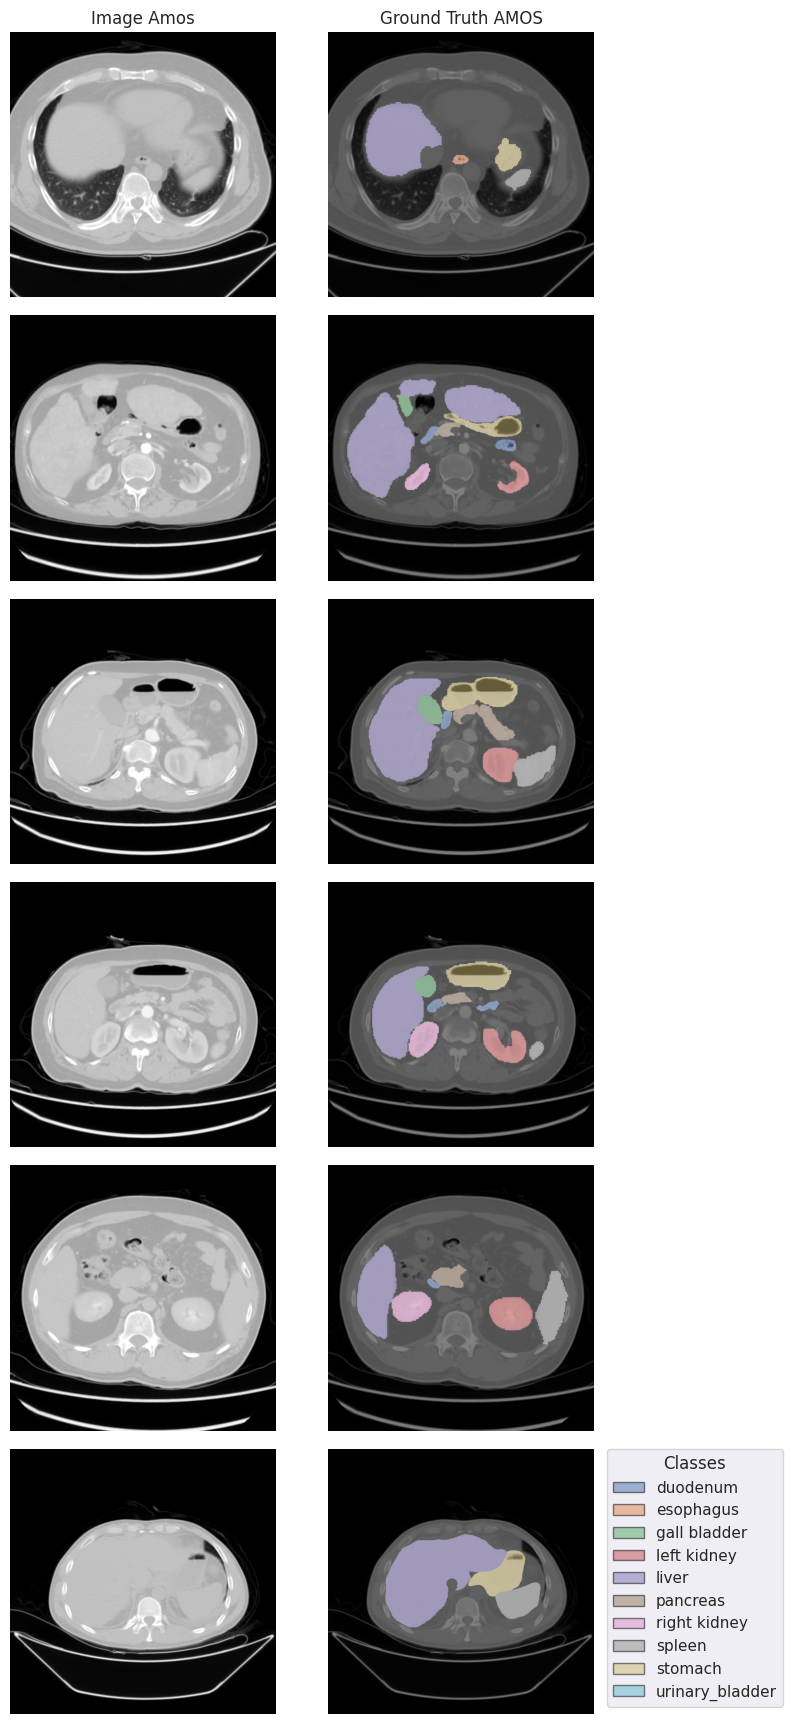

In [6]:
idx = 50
num_plots = len(imgs)
fig, axs = plt.subplots(num_plots, 2 ,figsize=(9, 3*num_plots))

for k, (img, seg) in enumerate(zip(imgs, segs)):
    
    inputs = img.squeeze().numpy()
    target = seg.squeeze().numpy()
    x = inputs[idx:-idx,idx:-idx]
    t = target[idx:-idx,idx:-idx]

    new_t = np.zeros((*t.shape, 3))

    for i, c in color_dict.items():
        try:
            new_t[t==i+1, :] = c
        except Exception as e:
            print(f"Error: {e}")
    for ax in axs[k, :]:
        ax.imshow(x, cmap='gray', origin='lower')
        ax.set_axis_off()
    axs[k, 1].imshow(new_t, alpha=0.5, origin='lower')

axs[0, 0].set_title('Image Amos')
axs[0, 1].set_title('Ground Truth AMOS')
legend_elements = [
    Patch(facecolor=color_dict[i], edgecolor='black', label=l, alpha=0.5)
    for i, l in enumerate(labels) 
]
plt.legend(
    title="Classes",
    handles=legend_elements,
    bbox_to_anchor=(1.05, 1),  # Puts legend outside the plot
    loc='upper left',
    borderaxespad=0.
)
fig.tight_layout()
plt.show()

In [7]:
from testutils import prediction_with_patching
from inference import Model
from train import get_trainer, get_plans_and_dataset_json
DEVICE = "cuda:0"
from config import get_default_config
master_plan, master_dataset_json = get_plans_and_dataset_json(
    "Dataset003_TotalSegmentator", plans_identifier="nnUNetPlans"
)
train_ids = [
    "Dataset004_LiTS",
    "Dataset005_BTCV",
    "Dataset008_abdomenct1k",
    "Dataset009_learn2reg",
    "Dataset003_TotalSegmentator",
]
cfg = get_default_config("centralized")

master_trainer = get_trainer(
    configuration=cfg.nnunet.config,
    fold=cfg.fold,
    device=torch.device(DEVICE),
    plans=master_plan,
    dataset_json=master_dataset_json,
)
patch_size = master_plan["configurations"]["2d"]["patch_size"]
dropout_master = deepcopy(master_trainer)
dropout_master.configuration_manager.network_arch_init_kwargs[
    "dropout_op"
] = f"torch.nn.Dropout2d"
dropout_master.configuration_manager.network_arch_init_kwargs[
    "dropout_op_kwargs"
] = {"p": 0.2}

master_trainer.initialize()
dropout_master.initialize()

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################



/home/asim.ukaye/.conda/envs/miccai/lib/python3.12/site-packages/nnunetv2/training/nnUNetTrainer/nnUNetTrainer.py:165: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.grad_scaler = GradScaler() if self.device.type == 'cuda' else None


2025-04-09 14:03:38.303619: Using torch.compile...


/home/asim.ukaye/.conda/envs/miccai/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


2025-04-09 14:03:43.916153: Using torch.compile...


In [8]:
mode = 'cen'
ckpt_root = Path(ROOT_PATH) / "output/25-04-03/central/13-52-43"
ckpt_num = "700"
train_ckpt_path = ckpt_root / f"ckpt_{ckpt_num}.pt"
ckpt = torch.load(train_ckpt_path, map_location=DEVICE)["model"]
model_ckpt2 = {}
for k, v in ckpt.items():
    # if "all_modules.2" in k:
    if False:
        model_ckpt2[k.replace("all_modules.2", "all_modules.1")] = v
    else:
        model_ckpt2[k] = v
cen_model = Model(
            dataset_names=train_ids,
            label_subsets=LABEL_SUBSETS,
            master_trainer=deepcopy(dropout_master),
        ).to(DEVICE)
cen_model.load_state_dict(model_ckpt2)

/tmp/ipykernel_117755/4062758030.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(train_ckpt_path, map_location=DEVICE)["model"]


<All keys matched successfully>

In [21]:
mode = 'fed'
ckpt_root = Path(ROOT_PATH) /  "output/25-04-03/federated/12-42-08"
ckpt_num = "700"

train_ckpt_path = ckpt_root / f"ckpt_server_{ckpt_num}.pt"

backbone_ckpt_og = torch.load(train_ckpt_path, map_location=DEVICE)
backbone_ckpt = {}

for k, v in backbone_ckpt_og.items():
    # if "all_modules.2" in k:
    if False:
        backbone_ckpt[k.replace("all_modules.2", "all_modules.1")] = v
    else:
        backbone_ckpt[k] = v
fed_model = Model(
            dataset_names=train_ids,
            label_subsets=LABEL_SUBSETS,
            master_trainer=deepcopy(dropout_master),
        ).to(DEVICE)
fed_model.backbone.load_state_dict(backbone_ckpt)

for train_ds_name in train_ids:
    cls_head_ckpt = torch.load(
        ckpt_root / f"ckpt_{train_ds_name}_{ckpt_num}.pt",
        map_location=DEVICE,
    )
    fed_model.cls_heads[train_ds_name].load_state_dict(cls_head_ckpt)


/tmp/ipykernel_117755/1429619874.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  backbone_ckpt_og = torch.load(train_ckpt_path, map_location=DEVICE)
/tmp/ipykernel_11775

In [ ]:
mode = 'fvf'
ckpt_root = Path(ROOT_PATH) / "output/25-04-06/fiva/13-57-03"
ckpt_num = "700"
train_ckpt_path = ckpt_root / f"ckpt_server_{ckpt_num}.pt"

backbone_ckpt_og = torch.load(train_ckpt_path, map_location=DEVICE)

backbone_ckpt = {}
for k, v in backbone_ckpt_og.items():
    if "all_modules.2" in k:
    # if False:
        backbone_ckpt[k.replace("all_modules.2", "all_modules.1")] = v
    else:
        backbone_ckpt[k] = v
fvf_model = Model(
            dataset_names=train_ids,
            label_subsets=LABEL_SUBSETS,
            master_trainer=deepcopy(master_trainer),
        ).to(DEVICE)

fvf_model.backbone.load_state_dict(backbone_ckpt)

for train_ds_name in train_ids:
    cls_head_ckpt = torch.load(
        ckpt_root / f"ckpt_{train_ds_name}_{ckpt_num}.pt",
        map_location=DEVICE,
    )
    fvf_model.cls_heads[train_ds_name].load_state_dict(cls_head_ckpt)

backbone_variance_dict = torch.load(
    ckpt_root / f"variances/ckpt_server_var_{ckpt_num}.pt",
    map_location=DEVICE,
)
variance_ckpt = deepcopy(backbone_ckpt)
for k in variance_ckpt.keys():
    if "decoder.encoder" in k:
        k1 = k.replace("decoder.", "")
    else:
        k1 = k

    if "all_modules.1" in k1:
        variance_ckpt[k] = backbone_variance_dict[
            k1.replace("all_modules.1", "norm")
        ]
    elif "all_modules.0" in k1:
        variance_ckpt[k] = backbone_variance_dict[
            k1.replace("all_modules.0", "conv")
        ]
    else:
        variance_ckpt[k] = backbone_variance_dict[k1]

/tmp/ipykernel_117755/3333243440.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  backbone_ckpt_og = torch.load(train_ckpt_path, map_location=DEVICE)
/tmp/ipykernel_11775

In [10]:
vpath = Path('visuals')


In [ ]:
case_id = 4
img_new_slice = imgs[case_id]
seg_new_slice = segs[case_id]
case = slices_to_viz[case_id][1]
slice = slices_to_viz[case_id][0]
print(case, slice)
img_np = img_new_slice.squeeze().numpy()
seg_np = seg_new_slice.squeeze().numpy()

np.save(vpath/ f"target_{case}_{slice}", seg_np)
np.save(vpath/ f"img_{case}_{slice}", img_np)

amos_0098 70


In [ ]:

mc_iters = 10

mc_outputs = []
if mode == 'cen':
    model = cen_model
elif mode == 'fed':
    model = fed_model
elif mode == 'fvf':
    model = fvf_model
    model_weights = fvf_model.backbone.state_dict()


for _ in range(mc_iters):
    with torch.no_grad():
        if mode == 'fvf':
            sample_weights = {}
            for k, v in variance_ckpt.items():
                sample_weights[k] = torch.normal(model_weights[k], v)
            fvf_model.backbone.load_state_dict(sample_weights)


        out = prediction_with_patching(
            model, img_new_slice.to(DEVICE)[None], patch_size, DEVICE
        )
        out_softmax = {
            k: torch.softmax(v.permute(1, 0, 2, 3).cpu(), dim=1) for k, v in out.items()
        }
        mc_outputs.append(out_softmax)

mc_outputs_collated = {}
for train_ds_name in train_dataset_names:
    mc_outputs_collated[train_ds_name] = torch.cat(
        [o[train_ds_name] for o in mc_outputs], dim=0
    )

In [43]:
from inference import uncertainty,merged_logits_from_sep_cls, merged_logits_from_sep_cls_with_uncert, onehot, hard_dice_score, get_tp_fp_fn_tn, _sum
mean_logits, uncerts = [], []
preds = {}
ds_logits = {}

for train_ds_name, mc_outputs in mc_outputs_collated.items():
    mean, uncert, ale, epi = uncertainty(mc_outputs, var="sum")
    # print("Mean shape", mean.shape)
    # print("Uncert shape", uncert.shape)
    mean_new = torch.zeros(
        len(train_labels) + 1, mean.size(1), mean.size(2)
    )
    # print("Mean new shape", mean_new.shape)
    # ic(mean_new.shape)
    mean_new[0] = mean[0]
    # ic(mean.shape)
    ds_label_subset = np.array(label_subsets[train_ds_name])

    for k, i in train_labels.items():
        if k in ds_label_subset:
            # print(np.argwhere(ds_label_subset == k).shape)
            # print(np.argwhere(ds_label_subset == k)[0,0])
            mean_new[i] = mean[
                np.argwhere(ds_label_subset == k)[0, 0] + 1
            ]

    mean_logits.append(mean_new[None])
    uncerts.append(uncert)

    if train_ds_name not in preds:
        preds[train_ds_name] = []
    ds_pred = mean_new.argmax(0, keepdim=True)
    # print(ds_pred.shape)
    preds[train_ds_name].append(ds_pred)

    if train_ds_name not in ds_logits:
        ds_logits[train_ds_name] = []
    ds_logit = mean_new[None]
    # print(ds_logit.shape)
    ds_logits[train_ds_name].append(ds_logit)

merged_logits = merged_logits_from_sep_cls(mean_logits)
# print("Merged logits", merged_logits.shape)

merged_logits_fun = merged_logits_from_sep_cls_with_uncert(
    mean_logits, uncerts
)

sum_uncers = _sum(uncerts)
# print("Sum uncers", sum_uncers.shape)


merged_pred = merged_logits.argmax(dim=1, keepdim=True)
print("Merged pred", merged_pred.shape)
merged_pred_fun = merged_logits_fun.argmax(dim=1, keepdim=True)

target_onehot = onehot(seg_new_slice[None], n_cls=n_cls)
# print("Target onehot", target_onehot.shape)
merged_pred_onehot = onehot(merged_pred, n_cls=n_cls)
# print("Merged pred onehot", merged_pred_onehot.shape)
merged_pred_fun_onehot = onehot(merged_pred_fun, n_cls=n_cls)

dice = hard_dice_score(merged_pred_onehot, target_onehot)[1:]
dice_fun = hard_dice_score(merged_pred_fun_onehot, target_onehot)[
    1:
]

mask = np.zeros((n_cls - 1,))
mask[(torch.unique(seg_new_slice)[1:] - 1).long()] = 1
mask = mask.astype(bool)

tp, fp, fn, _ = get_tp_fp_fn_tn(
    merged_pred_onehot, target_onehot.to(torch.bool), axes=(0, 2, 3)
)
tp[1:][~mask] = 0
fp[1:][~mask] = 0
fn[1:][~mask] = 0

tp_fun, fp_fun, fn_fun, _ = get_tp_fp_fn_tn(
    merged_pred_fun_onehot,
    target_onehot.to(torch.bool),
    axes=(0, 2, 3),
)
tp_fun[1:][~mask] = 0
fp_fun[1:][~mask] = 0
fn_fun[1:][~mask] = 0


# then ignored py pandas
dice[~mask] = np.nan
dice_fun[~mask] = np.nan

print("Slice:", case)
print("OG dice:", np.nanmean(dice[mask]))
print("FUN dice:", np.nanmean(dice_fun[mask]))


dice = {l: d for l, d in zip(train_labels, dice)}
dice_fun = {f"{l}_fun": d for l, d in zip(train_labels, dice_fun)}

Merged pred torch.Size([1, 1, 585, 585])
Slice: amos_0098
OG dice: 0.5779959972633785
FUN dice: 0.6480712236711853


In [44]:
pred = merged_pred.squeeze().detach().numpy()
pred_fun = merged_pred_fun.squeeze().detach().numpy()
uncert_np = sum_uncers.squeeze().detach().numpy()
np.save(vpath/ f"{mode}_pred_{case}_{slice}.npy", pred)
np.save(vpath/ f"{mode}_pred_fun_{case}_{slice}.npy", pred_fun)
np.save(vpath/ f"{mode}_uncert_{case}_{slice}.npy", uncert_np)

In [ ]:
case_id = 2
slice, case = slices_to_viz[case_id]
# mode = 'cen'
# mode = 'fed'
mode = 'fvf'
img = np.load(vpath/ f"img_{case}_{slice}.npy")
gt = np.load(vpath/ f"target_{case}_{slice}.npy")

In [12]:
visible_labels =np.unique(gt)

In [13]:
pred = np.load(vpath/ f"{mode}_pred_{case}_{slice}.npy")
pred_fun = np.load(vpath/ f"{mode}_pred_fun_{case}_{slice}.npy")
uncert = np.load(vpath/ f"{mode}_uncert_{case}_{slice}.npy")

cen_pred = np.load(vpath/       f"cen_pred_{case}_{slice}.npy")
cen_pred_fun = np.load(vpath/   f"cen_pred_fun_{case}_{slice}.npy")
cen_uncert = np.load(vpath/     f"cen_uncert_{case}_{slice}.npy")

fed_pred = np.load(vpath/       f"fed_pred_{case}_{slice}.npy")
fed_pred_fun = np.load(vpath/   f"fed_pred_fun_{case}_{slice}.npy")
fed_uncert = np.load(vpath/     f"fed_uncert_{case}_{slice}.npy")

fvf_pred = np.load(vpath/       f"fvf_pred_{case}_{slice}.npy")
fvf_pred_fun = np.load(vpath/   f"fvf_pred_fun_{case}_{slice}.npy")
fvf_uncert = np.load(vpath/     f"fvf_uncert_{case}_{slice}.npy")

In [14]:
idx = 80
x = img[idx:-idx,idx:-idx]
t = gt[idx:-idx,idx:-idx]

cen_u = cen_uncert[idx:-idx,idx:-idx]
cen_vl = cen_pred[idx:-idx,idx:-idx]
cen_ul = cen_pred_fun[idx:-idx,idx:-idx]
fed_u = fed_uncert[idx:-idx,idx:-idx]
fed_vl = fed_pred[idx:-idx,idx:-idx]
fed_ul = fed_pred_fun[idx:-idx,idx:-idx]
fvf_u = fvf_uncert[idx:-idx,idx:-idx]
fvf_vl = fvf_pred[idx:-idx,idx:-idx]
fvf_ul = fvf_pred_fun[idx:-idx,idx:-idx]


new_t = np.zeros((*t.shape, 3))
new_cen_vl = np.zeros((*t.shape, 3))
# new_cen_ul = np.zeros((*t.shape, 3))
new_fed_vl = np.zeros((*t.shape, 3))
new_fed_ul = np.zeros((*t.shape, 3))
new_fvf_vl = np.zeros((*t.shape, 3))
new_fvf_ul = np.zeros((*t.shape, 3))
for i, c in color_dict.items():
    try:
        new_t[t==i+1,:] = c
        new_cen_vl[cen_vl==i+1,:] = c
        new_fed_vl[fed_vl==i+1,:] = c
        new_fed_ul[fed_ul==i+1,:] = c
        new_fvf_vl[fvf_vl==i+1,:] = c
        new_fvf_ul[fvf_ul==i+1,:] = c
    except Exception as e:
        print(e)

In [18]:
import matplotlib.patches as mpatches

/tmp/ipykernel_499455/3651475306.py:63: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout()


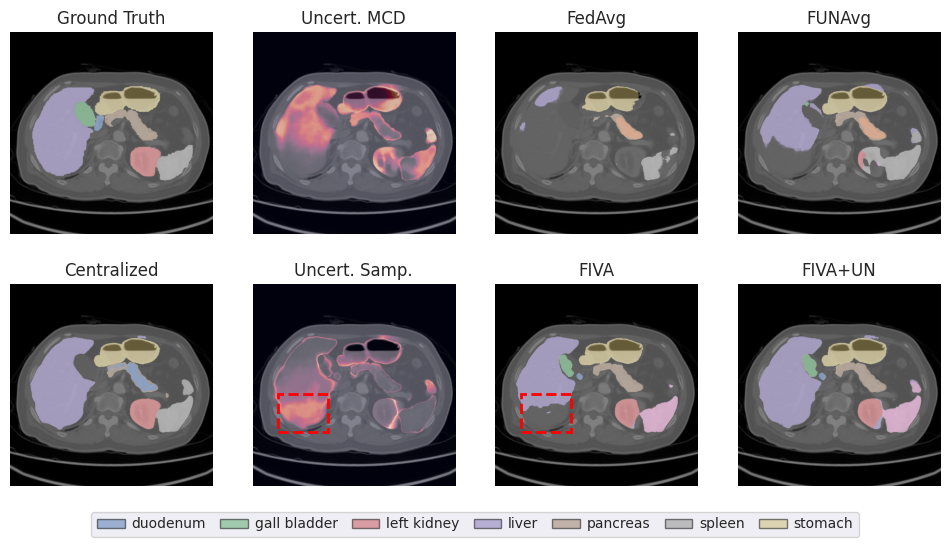

In [34]:
fig, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.reshape(-1):
    ax.imshow(x, cmap='gray', origin='lower')
    ax.set_axis_off()
axs[0,0].imshow(new_t, alpha=0.5, origin='lower')
axs[0,0].set_title('Ground Truth')

axs[1,0].imshow(new_cen_vl, alpha=0.5, origin='lower')
axs[1,0].set_title('Centralized')

axs[0,1].imshow(fed_u, alpha=0.5, origin='lower')
axs[0,1].set_title('Uncert. MCD')

axs[1,1].imshow(fvf_u, alpha=0.5, origin='lower')
axs[1,1].set_title('Uncert. Samp.')

axs[0,2].imshow(new_fed_vl, alpha=0.5, origin='lower')
axs[0,2].set_title('FedAvg')

axs[0,3].imshow(new_fed_ul, alpha=0.5, origin='lower')
axs[0,3].set_title('FUNAvg')

axs[1,2].imshow(new_fvf_vl, alpha=0.5, origin='lower')
axs[1,2].set_title('FIVA')

axs[1,3].imshow(new_fvf_ul, alpha=0.5, origin='lower')
axs[1,3].set_title('FIVA+UN')


for ax, img in zip(axs[1,1:3], [fvf_u, new_fvf_vl, new_fvf_ul]):
    x1, x2, y1, y2 = 80, 170, 100, 170
    bbox = mpatches.Rectangle((60, 130), 120, 90, linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
    ax.add_patch(bbox)
    # axins = inset_locator.inset_axes(ax, width="100%", height="100%", loc=4,
    #                                 bbox_to_anchor=(0.85,-0.35, 0.4, 0.4),
    #                                 bbox_transform=ax.transAxes)
    # axins.imshow(x, cmap='gray', origin='lower')
    # axins.imshow(img, alpha=0.5, origin='lower')
    # axins.set_xlim(x1, x2)
    # axins.set_ylim(y1, y2)
    # axins.set_axis_off()

    # from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    # mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5", facecolor='white')

legend_elements = [
    Patch(facecolor=color_dict[i], edgecolor='black', label=l, alpha=0.5)
    for i, l in enumerate(labels) if i+1 in visible_labels
]
plt.legend(
    # title="Labels",
    handles=legend_elements,
    bbox_to_anchor=(-1.3, -0.25),  # Puts legend outside the plot
    # loc='upper left',
    frameon=True,
    ncol=len(legend_elements),
    loc='lower center',
    borderaxespad=0.0,
    columnspacing=1.0,   # Reduce horizontal spacing
    handletextpad=0.5,   # Space between color box and text
    fontsize=10,
)
fig.tight_layout()
fig.savefig('qualitative_amos_marked.png', bbox_inches='tight')

plt.show()

In [ ]:
case_id = 3
slice, case = slices_to_viz[case_id]
img = np.load(vpath/ f"img_{case}_{slice}.npy")
gt = np.load(vpath/ f"target_{case}_{slice}.npy")
visible_labels =np.unique(gt)

In [38]:
pred = np.load(vpath/ f"{mode}_pred_{case}_{slice}.npy")
pred_fun = np.load(vpath/ f"{mode}_pred_fun_{case}_{slice}.npy")
uncert = np.load(vpath/ f"{mode}_uncert_{case}_{slice}.npy")

cen_pred = np.load(vpath/       f"cen_pred_{case}_{slice}.npy")
cen_pred_fun = np.load(vpath/   f"cen_pred_fun_{case}_{slice}.npy")
cen_uncert = np.load(vpath/     f"cen_uncert_{case}_{slice}.npy")

fed_pred = np.load(vpath/       f"fed_pred_{case}_{slice}.npy")
fed_pred_fun = np.load(vpath/   f"fed_pred_fun_{case}_{slice}.npy")
fed_uncert = np.load(vpath/     f"fed_uncert_{case}_{slice}.npy")

fvf_pred = np.load(vpath/       f"fvf_pred_{case}_{slice}.npy")
fvf_pred_fun = np.load(vpath/   f"fvf_pred_fun_{case}_{slice}.npy")
fvf_uncert = np.load(vpath/     f"fvf_uncert_{case}_{slice}.npy")
idx = 80
x = img[idx:-idx,idx:-idx]
t = gt[idx:-idx,idx:-idx]

cen_u = cen_uncert[idx:-idx,idx:-idx]
cen_vl = cen_pred[idx:-idx,idx:-idx]
cen_ul = cen_pred_fun[idx:-idx,idx:-idx]
fed_u = fed_uncert[idx:-idx,idx:-idx]
fed_vl = fed_pred[idx:-idx,idx:-idx]
fed_ul = fed_pred_fun[idx:-idx,idx:-idx]
fvf_u = fvf_uncert[idx:-idx,idx:-idx]
fvf_vl = fvf_pred[idx:-idx,idx:-idx]
fvf_ul = fvf_pred_fun[idx:-idx,idx:-idx]


new_t = np.zeros((*t.shape, 3))
new_cen_vl = np.zeros((*t.shape, 3))
# new_cen_ul = np.zeros((*t.shape, 3))
new_fed_vl = np.zeros((*t.shape, 3))
new_fed_ul = np.zeros((*t.shape, 3))
new_fvf_vl = np.zeros((*t.shape, 3))
new_fvf_ul = np.zeros((*t.shape, 3))
for i, c in color_dict.items():
    try:
        new_t[t==i+1,:] = c
        new_cen_vl[cen_vl==i+1,:] = c
        new_fed_vl[fed_vl==i+1,:] = c
        new_fed_ul[fed_ul==i+1,:] = c
        new_fvf_vl[fvf_vl==i+1,:] = c
        new_fvf_ul[fvf_ul==i+1,:] = c
    except Exception as e:
        print(e)

/tmp/ipykernel_499455/4087287207.py:47: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout()


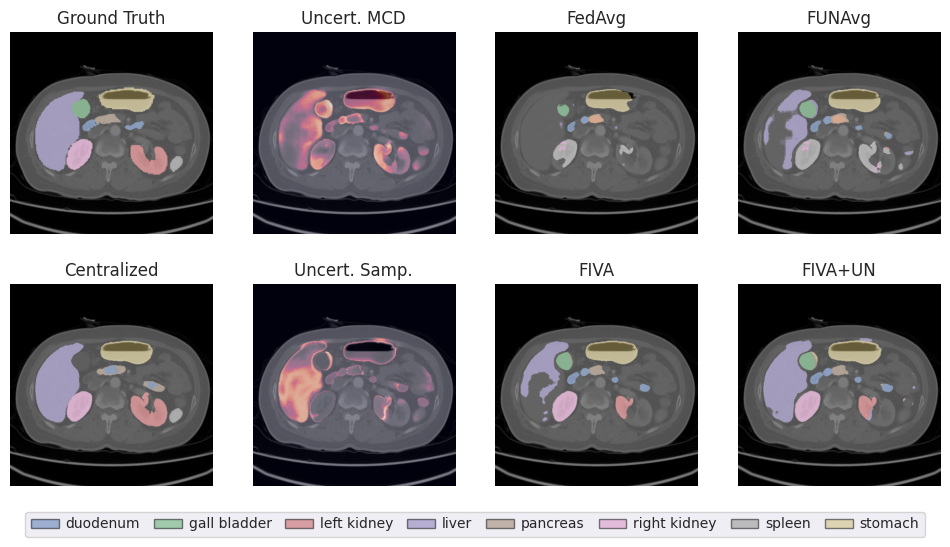

In [39]:
fig, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.reshape(-1):
    ax.imshow(x, cmap='gray', origin='lower')
    ax.set_axis_off()
axs[0,0].imshow(new_t, alpha=0.5, origin='lower')
axs[0,0].set_title('Ground Truth')

axs[1,0].imshow(new_cen_vl, alpha=0.5, origin='lower')
axs[1,0].set_title('Centralized')

axs[0,1].imshow(fed_u, alpha=0.5, origin='lower')
axs[0,1].set_title('Uncert. MCD')

axs[1,1].imshow(fvf_u, alpha=0.5, origin='lower')
axs[1,1].set_title('Uncert. Samp.')

axs[0,2].imshow(new_fed_vl, alpha=0.5, origin='lower')
axs[0,2].set_title('FedAvg')

axs[0,3].imshow(new_fed_ul, alpha=0.5, origin='lower')
axs[0,3].set_title('FUNAvg')

axs[1,2].imshow(new_fvf_vl, alpha=0.5, origin='lower')
axs[1,2].set_title('FIVA')

axs[1,3].imshow(new_fvf_ul, alpha=0.5, origin='lower')
axs[1,3].set_title('FIVA+UN')


legend_elements = [
    Patch(facecolor=color_dict[i], edgecolor='black', label=l, alpha=0.5)
    for i, l in enumerate(labels) if i+1 in visible_labels
]
plt.legend(
    # title="Labels",
    handles=legend_elements,
    bbox_to_anchor=(-1.3, -0.25),  # Puts legend outside the plot
    # loc='upper left',
    frameon=True,
    ncol=len(legend_elements),
    loc='lower center',
    borderaxespad=0.0,
    columnspacing=1.0,   # Reduce horizontal spacing
    handletextpad=0.5,   # Space between color box and text
    fontsize=10,
)
fig.tight_layout()
fig.savefig('qualitative_amos_marked.png', bbox_inches='tight')

plt.show()

In [23]:
from mpl_toolkits.axes_grid1 import inset_locator

In [ ]:
idx = 50

x = img[idx:-idx,idx:-idx]
t = gt[idx:-idx,idx:-idx]
u = uncert[idx:-idx,idx:-idx]
vl = pred[idx:-idx,idx:-idx]
feduwavgl = pred_fun[idx:-idx,idx:-idx]
new_t = np.zeros((*t.shape, 3))
new_vl = np.zeros((*t.shape, 3))
new_feduwavgl = np.zeros((*t.shape, 3))

for i, c in color_dict.items():
    try:
        new_t[t==i+1,:] = c
        new_vl[vl==i+1,:] = c
        new_feduwavgl[feduwavgl==i+1,:] = c
    except Exception as e:
        print(e)


In [50]:
%matplotlib inline

In [ ]:
# label_names = list(train_labels.keys())

idx = 50
inputs = img_new_slice.squeeze().numpy()
target = seg_new_slice.squeeze().numpy()
x = inputs[idx:-idx,idx:-idx]
t = target[idx:-idx,idx:-idx]
visible_labels =np.unique(t)
print(visible_labels)
new_t = np.zeros((*t.shape, 3))
# new_vl = np.zeros((*t.shape, 3))
# new_feduwavgl = np.zeros((*t.shape, 3))

for i, c in color_dict.items():
    # print(i+1,l,(t==i+1).sum())
    try:
        new_t[t==(i+1),:] = c#p[l] #i % len(cp)]
    except Exception as e:
        print(f"Error: {e}")
fig, axs = plt.subplots(1,2,figsize=(6,3))
for ax in axs:
    ax.imshow(x, cmap='gray', origin='lower')
    ax.set_axis_off()
axs[1].imshow(new_t, alpha=0.5, origin='lower')

axs[0].set_title('Image Amos')
axs[1].set_title('Ground Truth AMOS')
fig.tight_layout()
legend_elements = [
    Patch(facecolor=color_dict[i], edgecolor='black', label=l, alpha=0.5)
    for i, l in enumerate(labels) if i+1 in visible_labels
]
plt.legend(
    title="Classes",
    handles=legend_elements,
    bbox_to_anchor=(1.05, 1),  # Puts legend outside the plot
    loc='upper left',
    borderaxespad=0.
)
plt.show()

## Get index map

In [ ]:
from config import LABEL_SUBSETS
label_subsets = LABEL_SUBSETS
from config import ROOT_PATH
data_src = Path(ROOT_PATH) 

train_dataset_names = [
            "Dataset004_LiTS",
            "Dataset005_BTCV",
            "Dataset008_abdomenct1k",
            "Dataset009_learn2reg",
            "Dataset003_TotalSegmentator",
        ]
test_dataset_names = deepcopy(train_dataset_names)
test_dataset_names.append("Dataset001_amos")


index_map = []


train_labels = [label_subsets[ds_name] for ds_name in train_dataset_names]
train_labels = np.unique([xx for x in train_labels for xx in x])
train_labels = {l: i + 1 for i, l in enumerate(train_labels)}
n_cls = len(train_labels) + 1
print(n_cls)
print(train_labels)
test_dataset_labels = {}

test_dataset_cases: dict[str, list] = {}
    # test_dataset_lbl_files = {}
for ds_name in test_dataset_names:
    ds_dir = ds_name
    with open(
        data_src / "nnUNet_preprocessed" / ds_dir / "dataset.json", "r"
    ) as f:
        test_dataset_labels[ds_name] = json.load(f)["labels"]

    with open(
        data_src / "nnUNet_preprocessed" / ds_dir / "splits_final.json", "r"
    ) as f:
        fold_splits = json.load(f)
        test_dataset_cases[ds_name] = fold_splits[0]["val"]

for test_ds_name in test_dataset_names:
    all_test_ds_labels = test_dataset_labels[test_ds_name]
    test_ds_labels = label_subsets[test_ds_name]
    # Mask the labels that are not present in the dataset
    label_mask = np.array(
        [True if l in test_ds_labels else False for l in train_labels]
    )

    intersection_labels = [t for t in train_labels if t in test_ds_labels]
    if not len(intersection_labels):
        print(f"No intersection between train and test labels for {test_ds_name}")
        continue

    print(test_ds_name)

    ds_dir = test_ds_name
    cases = test_dataset_cases[test_ds_name]
    img_paths = [
        data_src
        / "nnUNet_preprocessed"
        / ds_dir
        / "nnUNetPlans_2d"
        / f"{case}.npy"
        for case in cases
    ]

    for k, (case, img_path) in enumerate(zip(cases, img_paths)):
        # Use only 20 images for now
        if k == 20:
            break

        seg_np = np.load(
            data_src
            / "nnUNet_preprocessed"
            / ds_dir
            / "nnUNetPlans_2d"
            / f"{case}_seg.npy"
        )
        seg = torch.tensor(seg_np).float()
        # Map the test labels to the training labels
        seg_new = torch.zeros_like(seg)
        for l, i in train_labels.items():
            if l in all_test_ds_labels:
                j = int(all_test_ds_labels[l])
                seg_new[seg == j] = i


        idxs = np.arange(seg_new.shape[1])
        # print(seg_new.shape)
        # Find foreground slices
        idx_mask = seg_new.sum((0, 2, 3)) > 0
        idxs = idxs[idx_mask]
        for e in idxs[::5]:
            # print(i)
            pr = {
                "case": case,
                "slice": e,
                "test_dataset": test_ds_name,
            }
            # print(pr)
            index_map.append(pr)
index_map = pd.DataFrame(index_map)
index_map.to_csv("abd_index_map.csv")

### Methodology

In [ ]:
labels = ['BG', 'Es', 'K', 'L', 'P', 'Spl', 'Sto']
data = {
    'D1': {
        'BG': [0.57, 0.55, 0.56], 
        'A': [0.15, 0.17, 0.15],
        'K': [0.13, 0.12, 0.14],
        'L': [0.15, 0.16, 0.15],
        
    },
    'D2': {
        'BG': [0.82,0.83, 0.81], 
        'Sto': [0.18,0.17,0.19]
    },
    'D3': {
        'BG': [0.33,0.34,0.37], 
        'K': [0.1,0.06,0.11],
        'P': [0.06,0.06,0.05], 
        'Spl': [0.51,0.54,0.47], 
    }
}
logits = {d: np.array(list(p.values())).T for d, p in data.items()}
[np.sum(np.array([vv for vv in v.values()]), axis=0) for v in data.values()]

In [ ]:
def uncertainty(p_hat, var='sum'):
    p_mean = np.mean(p_hat, axis=0)
    # print(p_mean)
    ale = np.mean(p_hat*(1-p_hat), axis=0)
    epi = np.mean(p_hat**2, axis=0) - p_mean**2
    if var == 'sum':
        ale = np.sum(ale, axis=0)
        epi = np.sum(epi, axis=0)
    elif var == 'top':
        ale = ale[np.argmax(p_mean)]
        epi = epi[np.argmax(p_mean)]
    uncert = ale + epi
    return p_mean, uncert, ale, epi

In [ ]:
p_hat = logits['D1']
p_hat*(1-p_hat)

In [ ]:
uncertainty(logits['D1'])

In [ ]:
preds_and_uncert = {d: uncertainty(l)[:2] for d, l in logits.items()}
uncerts = {d: u for d, (_,u) in preds_and_uncert.items()}
preds = {d: p for d, (p,_) in preds_and_uncert.items()}
preds = {d: {list(data[d])[i]: pp for i, pp in enumerate(p)} for d, p in preds.items()}

In [ ]:
cp = {l: c for l, c in zip(labels[1:], sns.color_palette())}
cp['BG'] = 'gray'
uncert_color = sns.color_palette("rocket")[-4]

In [ ]:
sns.color_palette()

In [ ]:
sns.color_palette("rocket")

In [ ]:
preds_new = []
for d, p in preds.items():
    p_new = np.zeros((len(labels),))
    for l, op in p.items():
        p_new[np.argwhere(np.array(labels)==l)[0,0]] = op
    preds_new.append(p_new)
vanilla_pred = np.array(preds_new)
vanilla_pred = vanilla_pred.sum(axis=0) / (vanilla_pred > 0).sum(axis=0)
mean_uncert = np.mean(list(uncerts.values()))

In [ ]:
fig, axs = plt.subplots(1,5,figsize=(15,4))#,sharey=True)

for ax, (ds, p), w in zip(axs, preds.items(), [0.5, 0.25, 0.5]): # [0.8,0.8,0.8]): #
    for x, (k, op) in enumerate(p.items()):
        ax.bar(x, op, color=cp[k], width=w)
    ax.bar(x+1,uncerts[ds],color=uncert_color, width=w)
    ax.set_xticks(np.arange(len(p)+1))
    ax.set_xticklabels([o.capitalize() for o in p]+['U'],rotation=90,fontsize=15)
    ax.set_ylim([-0.02,1.02])
    ax.set_ylabel(r'$p$')
    
ax = axs[3]
for x, (l, p) in enumerate(zip(labels, vanilla_pred)):
    ax.bar(x, p, color=cp[l], width=0.8)
ax.bar(x+1,mean_uncert,color=uncert_color, width=0.8)
ax.set_xticks(np.arange(len(labels)+1))
ax.set_xticklabels([l.capitalize() for l in labels]+['U'],rotation=90,fontsize=15)
ax.set_ylim([-0.02,1.02])
ax.set_ylabel(r'$\tilde{p}$')

ax = axs[4]
ax.bar(-0.2, vanilla_pred[0], color=cp['BG'], width=0.4, alpha=0.6, label=r'$p_{bg}$')
for x, (l, p) in enumerate(zip(labels[1:], vanilla_pred[1:])):
    ax.bar(x+1, p, color=cp[l], width=0.8, alpha=1.0)
ax.bar(0.2,1-mean_uncert,color=uncert_color,alpha=0.6, width=0.4, label=r'$1-u$')
ax.bar(0,vanilla_pred[0]*(1-mean_uncert),color='black', width=0.4, label=r'$p_{bg} \times (1-u)$')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels([l.capitalize() for l in labels],rotation=90,fontsize=15)
ax.set_ylim([-0.02,1.02])
ax.set_ylabel(r'$\tilde{p}$')
ax.legend(loc='upper left', fontsize=8)

for ax, title in zip(axs, ['Seg. Head 1', 'Seg. Head 2', 'Seg. Head 3', 'Averaged Softmax Probs', 'FUNAvg.']):
    ax.set_title(title)

fig.tight_layout()
fig.savefig('method_funavg.png', bbox_inches='tight')